In [1]:
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread, imsave
import cv2

In [3]:
image_path = '/home/ubuntu/nerf_ws/NeuRay/data/DTU_MVS/dtu_training/Rectified/scan114_train/rect_001_3_r5000.png'

ref_img = imread(image_path)

src_imgs = []
for idx in [6, 10, 15, 20, 29, 32, 35]:
    image_path = f'/home/ubuntu/nerf_ws/NeuRay/data/DTU_MVS/dtu_training/Rectified/scan114_train/rect_{idx+1:03d}_3_r5000.png'

    src_imgs.append(imread(image_path))

src_imgs = [src_imgs[i] for i in [1, 2, 0, 4, 5, 3, 6]]

In [4]:
with open('/home/ubuntu/nerf_ws/NeuRay/data/model/neuray_ft_scan114_cv_640_512_scalarsigmaprompt_fulltensor_blend_debug/render_1/consis_weight_cosin_detail2.pkl', 'rb') as handle:
    prj_img_feats = pickle.load(handle)['prj_img_feats']

with open('/home/ubuntu/nerf_ws/NeuRay/data/model/neuray_ft_scan114_cv_640_512_scalarsigmaprompt_fulltensor_blend_debug/render_1/consis_weight_cosin_detail.pkl', 'rb') as handle:
    pk_dict = pickle.load(handle)
    prj_pts = pk_dict['prj_pts']
    prj_rgb = pk_dict['prj_rgb']
    consis_weight = pk_dict['consistent_weights']
    que_depth = pk_dict['que_depth']

In [5]:
from dataset.database import read_depth

def get_depth(depth_filename):
    # depth_filename = os.path.join(self.root_dir, f'Depths_raw/{self.model_name}/depth_map_{img_id:04d}.pfm')
    depth_map = read_depth(depth_filename) * 1./200
    return depth_map

depth_gt = get_depth('/home/ubuntu/nerf_ws/NeuRay/data/DTU_MVS/dtu_training/Depths_raw/scan114/depth_map_0000.pfm')

In [25]:
x = 420
y = 180
d_sample = 47

In [24]:
gt_val = depth_gt[y, x]
que_d = que_depth[y, x]

diff_depth = np.abs(que_d- gt_val)
print('gt', np.argmin(diff_depth))

print('pred', np.argmax(consis_weight[y,x]))

gt 47
pred 17


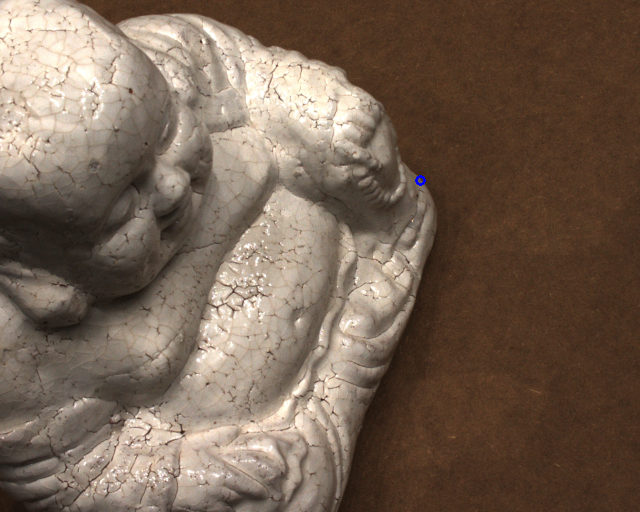

In [23]:
img2 = ref_img.copy()
img2 = cv2.circle(img2, (x, y), 4, (0,0,255), 2)
display(Image.fromarray(img2))


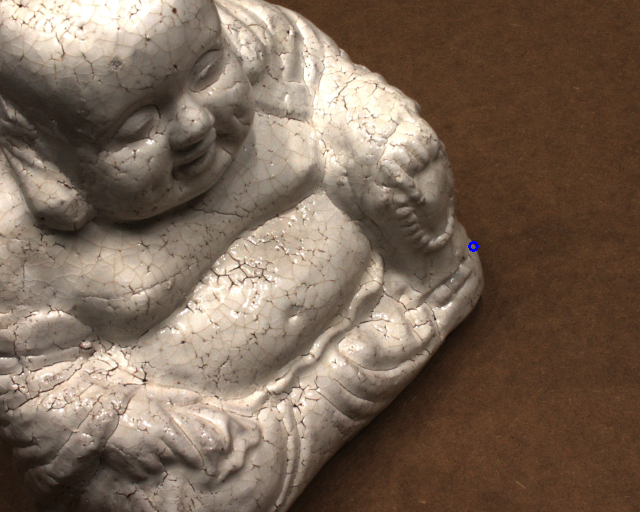

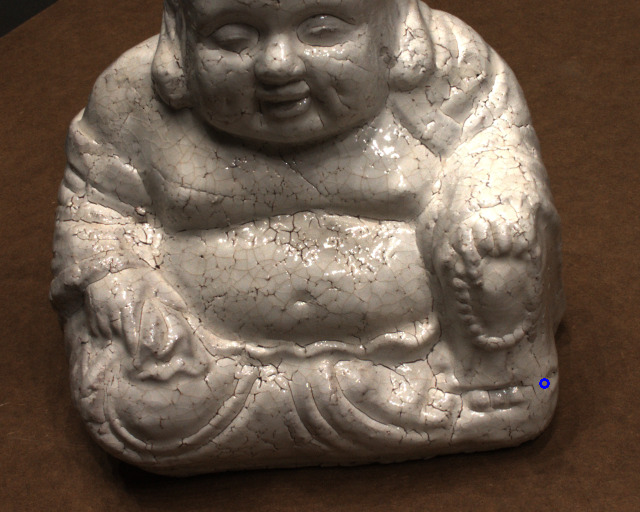

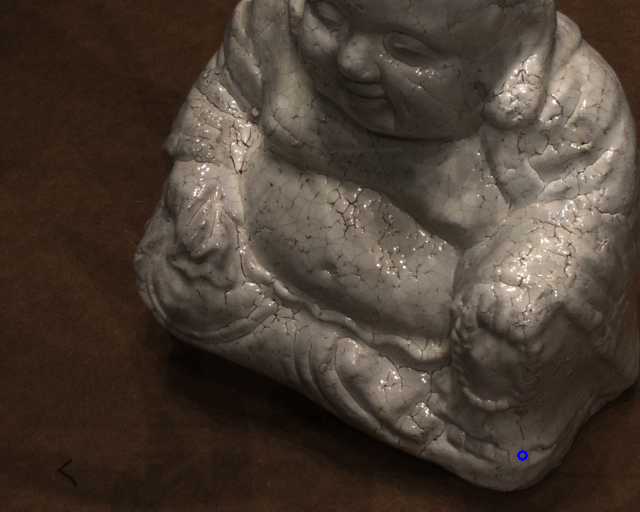

In [26]:
prj_pt = prj_pts[y, x, d_sample].astype(np.int32)


for i in range(3):
    src_img_cp = src_imgs[i].copy()
    src_img_cp = cv2.circle(src_img_cp, (prj_pt[i, 0], prj_pt[i, 1]), 4, (0,0,255), 2)
    display(Image.fromarray(src_img_cp))

# src_img1 = src_imgs[1].copy()
# src_img1 = cv2.circle(src_img1, (455, 275), 4, (0,0,255), 2)
# display(Image.fromarray(src_img1))

# src_img2 = src_imgs[2].copy()
# src_img2 = cv2.circle(src_img2, (454, 327), 4, (0,0,255), 2)
# display(Image.fromarray(src_img2))




In [22]:
feat_vec = np.array([src_img0[206, 398], src_img1[275, 455], src_img2[327, 454]])
feat_vec = feat_vec / 255. # N, 3

feat_mat = np.sum(feat_vec[None, :, :] * feat_vec[:, None, :], axis=-1)
feat_mat[0,0] = -1e6
feat_mat[1,1] = -1e6
feat_mat[2,2] = -1e6

print(feat_mat)

[[0.27058824 0.22745098 0.2       ]
 [0.29411765 0.25490196 0.20392157]
 [0.23921569 0.20784314 0.18431373]]
[[-1.00000000e+06  1.78346790e-01  1.48865821e-01]
 [ 1.78346790e-01 -1.00000000e+06  1.60922722e-01]
 [ 1.48865821e-01  1.60922722e-01 -1.00000000e+06]]


In [14]:
# prj_img_feats = np.concatenate([pk_dict['prj_img_feats'][y, x, 40], pk_dict2['prj_rgb'][y, x, 40]], axis=-1)
# prj_img_feats = pk_dict['prj_img_feats'][y, x, 40]
prj_img_feat = prj_img_feats[y, x, d_sample]

prj_img_feat1 = prj_img_feat[None, :, :]
prj_img_feat2 = prj_img_feat[:, None, :]

prj_img_mat = np.sum(prj_img_feat1 * prj_img_feat2, axis=-1) / (np.linalg.norm(prj_img_feat1, axis=-1) * np.linalg.norm(prj_img_feat2, axis=-1))

for i in range(prj_img_mat.shape[0]):
    prj_img_mat[i, i] = -1e6
    
print(prj_img_mat.shape)
print(np.max(prj_img_mat))

(7, 7)
0.9326353
